In [1]:
from DC import DCModel
from FLORIS_PT import FLORIS_PT
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mplcolors
import copy
import time

import floris
from floris.tools import FlorisInterface
from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

plt.rcParams.update({'font.size': 20})

### Inputs

In [2]:
# input files to define turbine type, wind conditions, and FLORIS model parameters
input_file_path = "./inputs.yaml"
floris_pt = FLORIS_PT(input_file_path)

# wind farm layout
D = floris_pt.turbine['rotor_diameter']
x_coord = torch.tensor([0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D,
                        0., 6.*D, 12.*D])
            
y_coord = torch.tensor([6.*D, 6.*D, 6.*D,
                        3.*D, 3.*D, 3.*D,
                        0., 0., 0., ])
z_hh = floris_pt.turbine['hub_height']
nturbs = len(x_coord)
z_coord = torch.tensor([z_hh] * nturbs)

# dropout
dropout=True
active_prob = .5 # probability turbine is active during training

# set bounds on allowed yaw angle
# umin 0 by default (controlled by sigmoid)
umax = torch.tensor([25.0]) # maximum allowed yaw angle (degrees)
umin = torch.tensor([-25.0]) # minimum allowed yaw angle (degrees)

# hyperparameters
lr = .00025
batch_size = 50
N_batches = 50
N_epochs = 10
hidden_dim = 128

# neural network parameters
model_config = dict({"n_turbines": nturbs, 
                     "hidden_dim": hidden_dim, 
                     "dropout": dropout})

# generate training data
# ws from [ws_min, ws_max]; m/s
# ws_max = 8.0
ws_max = 11.4
ws_min = 3.0
ws_training = torch.rand((N_batches, batch_size, 1)) * (ws_max - ws_min) + ws_min 
wd_fixed = 275.
wd_training = wd_fixed * torch.ones(N_batches, batch_size, 1)

# number of turbines active
active_turbs_training = torch.rand((N_batches, batch_size, nturbs)) < active_prob
# ensure at least 1 turbine is active
for batch in range(N_batches):
    for sample in range(batch_size):
        active_turbs= active_turbs_training[batch, sample, :]
        while torch.all(active_turbs == torch.tensor([False] * nturbs)):
            active_turbs_training[batch, sample, :] = torch.rand(nturbs) < active_prob

# pick validation set
ws_validation = torch.tensor([4., 6., 8., 10.]) # m/s
wd_validation = torch.tensor([wd_fixed]) # degrees
active_turbs_validation = torch.tensor([[True, True, True, 
                                         True, True, False, 
                                         True, False, False],
                                        [True, True, True, 
                                         True, True, True, 
                                         True, False, False],
                                        [True, True, True, 
                                         True, True, True, 
                                         True, True, False],
                                        [True, True, True, 
                                         True, True, True, 
                                         True, True, True]])

# pick test set
ws_test = torch.tensor([3, 4, 5, 6, 7, 8, 9, 10, 11])
wd_test = torch.clone(wd_validation)
active_turbs_test = torch.clone(active_turbs_validation)

# training time (FLORIS)
ws_runtime = torch.clone(ws_test)
wd_runtime = torch.clone(wd_test)
active_turbs_runtime = torch.tensor([[True, True, False, 
                                      False, False, False, 
                                      False, False, False],
                                     [True, True, True, 
                                      False, False, False, 
                                      False, False, False],
                                     [True, True, True, 
                                      True, False, False, 
                                      False, False, False],
                                     [True, True, True, 
                                      True, True, False, 
                                      False, False, False],
                                     [True, True, True, 
                                      True, True, False, 
                                      True, False, False],
                                     [True, True, True, 
                                      True, True, True, 
                                      True, False, False],
                                     [True, True, True, 
                                      True, True, True, 
                                      True, True, False],
                                     [True, True, True, 
                                      True, True, True, 
                                      True, True, True]])

### Helper functions to apply DC to FLORIS-PT

In [3]:
# get control action from DC model
def get_control(model, ws, inds_sorted, ws_min, ws_max, active_turbs=None):
    # normalize features to range [0,1]
    ws_rep = ws.unsqueeze(dim=1)
    ws_norm = (ws_rep - ws_min)/(ws_max - ws_min)
    x = torch.cat([ws_norm, active_turbs], axis=1)
    u = model(x)
    scaled_u = torch.clone(u)*(umax-umin)+umin
    if active_turbs is not None:
        scaled_u = torch.where(active_turbs,scaled_u,torch.tensor(0.))
    scaled_u = torch.reshape(scaled_u, (x.shape[0], nturbs, 1, 1)) # unflatten
    scaled_u_sorted = torch.take_along_dim(scaled_u, inds_sorted, axis=1) # sort
    return scaled_u_sorted, scaled_u, u

# calculate average power over list of wind speeds
# modifies powers list to add this average power
def test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, \
    powers_validation, x_coord, y_coord, z_coord, ws_max, wd_max=360., active_turbs_validation=None):
    
    power_validation = 0.
    
    N = len(active_turbs_validation)
    for i in range(N):
        ws = ws_validation
        wd = wd_validation.repeat(ws_validation.shape[0])
        active_turbs = active_turbs_validation[i].repeat(ws_validation.shape[0], 1)

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # add farm power
        farm_power = torch.sum(p, dim=(1)) # sum over turbines
        farm_power_mean = torch.mean(farm_power).item()
        powers_plot[i].append(farm_power_mean)
        
        power_validation += farm_power_mean
        
    powers_validation.append(power_validation/N)

### Training

In [5]:
t0 = time.time()

# initialize DC model
model = DCModel(**model_config)

# initialize optimizer used for training
opt = torch.optim.Adam(model.parameters(), lr=lr)

# vectors to track training progress
opt_losses = []
powers_plot = [[] for i in range(len(active_turbs_validation))]
powers_validation = []

# calculate and record power over validation set 
# using control actions from untrained DC policy
test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
           x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)

power_best = powers_validation[-1]
model_best = copy.deepcopy(model)

for epoch in range(N_epochs):
    # reorder samples to randomize data in batches
    perm_i = torch.randperm(N_batches)
    perm_j = torch.randperm(batch_size)
    ws_training_ij = ws_training[perm_i][:,perm_j]
    wd_training_ij = wd_training[perm_i][:,perm_j]
    active_turbs_training_ij = active_turbs_training[perm_i][:,perm_j]

    for batch in range(N_batches):
        opt_loss = 0.

        # forward pass
        ws = ws_training_ij[batch, :].squeeze(dim=1)
        wd = wd_training_ij[batch, :].squeeze(dim=1)
        active_turbs = active_turbs_training_ij[batch, :]

        # generate mesh on turbine rotor
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted = \
            floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

        # sort active turbines
        active_turbs_sorted = torch.take_along_dim(
            active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

        # get control action
        scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
            active_turbs=active_turbs)

        # calculate field on rotor mesh
        flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
            x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
            mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

        # calculate turbine power
        p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
            active_turbs_sorted=active_turbs_sorted)

        # negative farm power (negative b/c optimizer minimizes loss)
        power_cost = -torch.sum(p)

        # sum over samples in batch
        opt_loss += power_cost / torch.sum(active_turbs)

        # normalize loss by batch size
        opt_loss /= batch_size

        # backward pass
        opt.zero_grad()
        opt_loss.backward()
        opt.step()

        # save losses
        opt_losses.append(opt_loss.detach().numpy())

        # calculate and record power over validation set 
        # using control actions from updated DC policy
        test_power(floris_pt, model, ws_validation, wd_validation, powers_plot, powers_validation, \
                   x_coord, y_coord, z_coord, ws_max, active_turbs_validation=active_turbs_validation)
       
        # save best model
        power_validation = powers_validation[-1]
        if power_validation > power_best:
            power_best = power_validation
            model_best = copy.deepcopy(model)
            
        # uncomment to track progress during training
        nturbs_active = torch.sum(active_turbs_validation,axis=1)
#         if (batch+1) % 50 == 0:
#             print("batch: %d/%d."%(batch+1, N_batches))
#             plt.plot(np.array(powers_plot[0])/nturbs_active[0], \
#                      color='tab:blue', linestyle='-', linewidth=3)
#             plt.plot(np.array(powers_plot[1])/nturbs_active[1], \
#                      color='tab:orange', linestyle='--', linewidth=3)
#             plt.plot(np.array(powers_plot[2])/nturbs_active[2], \
#                      color='tab:green', linestyle=':', linewidth=3)
#             plt.plot(np.array(powers_plot[3])/nturbs_active[3], \
#                      color='tab:purple', linestyle=':', linewidth=3)
#             plt.xlabel('batch')
#             plt.ylabel('avg power over validation WSs (kW) \n /number of active turbines')
#             fig = plt.gcf()
#             fig.set_size_inches(12,6)
#             plt.show()
            
#             plt.plot(np.array(powers_validation), linewidth=3)
#             plt.xlabel('batch')
#             plt.ylabel('avg power over validation set (kW)')
#             fig = plt.gcf()
#             fig.set_size_inches(12,6)
#             plt.show()
            
model = model_best

runtime_DC = time.time() - t0

### Testing: baseline and optimization w/ FLORIS

In [6]:
def get_optimal(x_coord, y_coord, ws_all, wd_all, active_turbs_all=None):
    fi = FlorisInterface("gch.yaml")
    ws = ws_all
    wd = wd_all
    N = 1
    if active_turbs_all is not None:
        N = len(active_turbs_all)
    runtimes = []
    yaws_opt = []
    powers_opt = []
    powers_baseline = []
    for i in range(N):
        # only include active tubines
        if active_turbs_all is not None:
            active_turbs = active_turbs_all[i]
            x = x_coord[active_turbs]
            y = y_coord[active_turbs]
        else:
            x = x_coord
            y = y_coord

        # pass the new data to FlorisInterface
        fi.reinitialize(
            layout=(x, y),
            wind_directions=wd,
            wind_speeds=ws
        )

        # calculate the velocities at each turbine for validation atmospheric conditions
        # validation turbines have 0 degrees yaw
        fi.calculate_wake()

        # initialize optimizer object and run optimization using the Serial-Refine method
        yaw_opt = YawOptimizationSR(fi, minimum_yaw_angle=-25.0, maximum_yaw_angle=25.0);

        # compute time
        t0 = time.time()
        df_opt = yaw_opt.optimize()
        runtime = time.time() - t0

        # outputs
        yaw_angles = np.stack(df_opt.yaw_angles_opt.to_numpy())
        power = np.stack(df_opt.farm_power_opt.to_numpy())/1000.0
        power_baseline = np.stack(df_opt.farm_power_baseline.to_numpy())/1000.0

        runtimes.append(runtime)
        yaws_opt.append(yaw_angles)
        powers_opt.append(power)
        powers_baseline.append(power_baseline)
        
    return runtimes, yaws_opt, powers_opt, powers_baseline

In [7]:
%%capture 
# ^ suppress printing from YawOptimizationSR

_, yaws_FLORIS, powers_FLORIS, powers_baseline = \
    get_optimal(x_coord, y_coord, ws_test, wd_test, active_turbs_all=active_turbs_test)


_, _, powers_FLORIS_validation, _ = \
    get_optimal(x_coord, y_coord, ws_validation, wd_validation, active_turbs_all=active_turbs_validation)

runtimes, _, _, _ = get_optimal(x_coord, y_coord, \
    ws_runtime, wd_runtime, active_turbs_all=active_turbs_runtime)

### Training plot

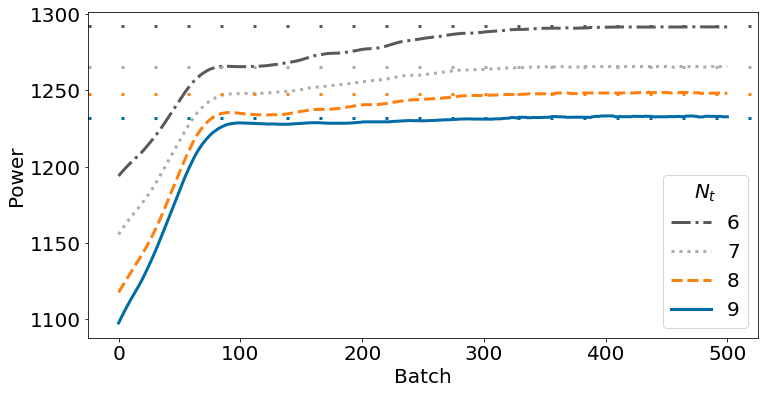

In [11]:
plt.style.use('tableau-colorblind10')                                                          
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({'font.size': 20})
plt.rc('lines', linewidth=3.0)

linestyles = ['-.', ':', '--', '-']

markerstyles = ['+', 'x', '*', 'o']
marker_names = ["DC", "Opt.", "Lookup", "Baseline"]

plt.rcParams.update({'lines.markersize': 20})

colors_training = [colors[3], colors[2], colors[1], colors[0]]
for i in range(4):
    nturbs_active = 6+i
    plt.plot(np.array(np.array(powers_plot[i])/nturbs_active), label=str(nturbs_active), 
        color=colors_training[i], linestyle=linestyles[i], linewidth=3)
    plt.axhline(np.mean(powers_FLORIS_validation[i])/nturbs_active, \
        color=colors_training[i], linestyle=(0, (1, 10)), linewidth=3)
    
plt.legend(title="$N_t$", prop={'size': 20})
plt.xlabel('Batch')
plt.ylabel('Power')
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.savefig('/Users/jani/Documents/research/windFarmControl/presentations/2023_ACC/figures_larger/training.png', 
             bbox_inches='tight')
plt.show()

# Loss averaged over the wind speeds in the validation set
# for each turbine status vector in the validation set, 
# labeled by the number of active turbines (6, 7, 8, or 9.)

### Testing plots

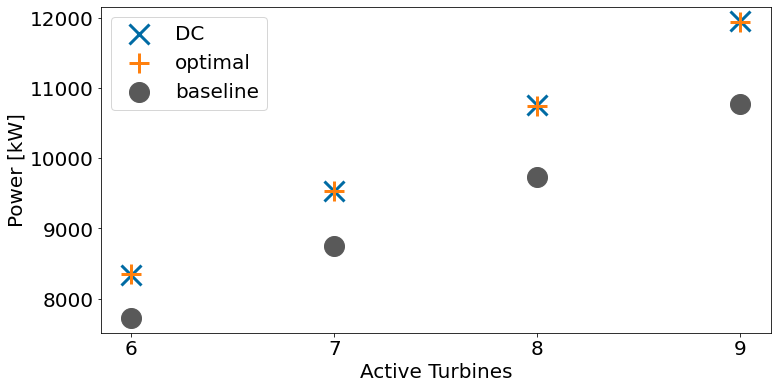

In [12]:
powers_DC = []

for i in range(len(active_turbs_test)):
    ws = ws_test
    wd = wd_test.repeat(ws.shape[0])
    active_turbs = active_turbs_test[i].repeat(ws.shape[0], 1)

    # generate mesh on turbine rotor
    x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted = \
        floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)

    # sort active turbines
    active_turbs_sorted = torch.take_along_dim(
        active_turbs.unsqueeze(-1).unsqueeze(-1), inds_sorted, axis=1)

    # get control action
    scaled_u_sorted, _, u = get_control(model, ws, inds_sorted, ws_min, ws_max, \
        active_turbs=active_turbs)

    # calculate field on rotor mesh
    flow_field_u, yaw_angle = floris_pt.get_field_rotor(ws, scaled_u_sorted, \
        x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
        mesh_y_rotated, mesh_z, inds_sorted, active_turbs_sorted=active_turbs_sorted)

    # calculate turbine power
    p = floris_pt.get_power(flow_field_u, x_coord_rotated, yaw_angle, \
        active_turbs_sorted=active_turbs_sorted)

    farm_power = torch.sum(p, axis=1).detach().numpy()

    powers_DC.append(farm_power)
    
nturbs_active = [6, 7, 8, 9]
plt.scatter(nturbs_active, [np.mean(p) for p in powers_DC], color=colors[0], \
            marker='x', label="DC")
plt.scatter(nturbs_active, [np.mean(p) for p in powers_FLORIS], color=colors[1], \
            marker='+', label="optimal")
plt.scatter(nturbs_active, [np.mean(p) for p in powers_baseline], \
            marker='o', color=colors[3], label="baseline")
plt.xlabel("Active Turbines")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
ax=plt.gca()
plt.xticks(ticks=nturbs_active, labels=[str(nt) for nt in nturbs_active])
plt.savefig('/Users/jani/Documents/research/windFarmControl/presentations/2023_ACC/figures_larger/testing_Nt.png', 
             bbox_inches='tight')
plt.show()

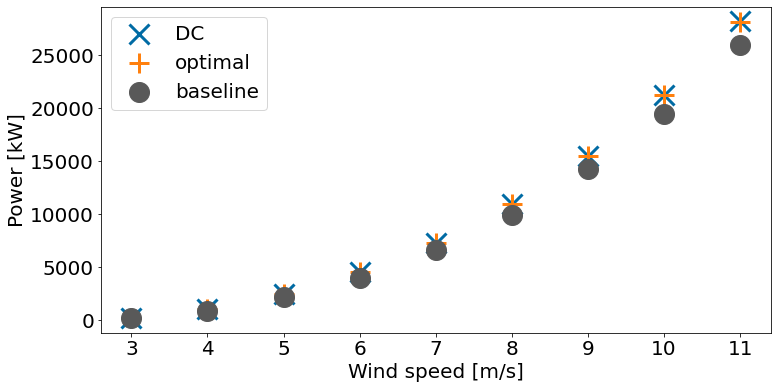

In [14]:
def t_to_ws(ps_t):
    ps_ws = np.zeros(len(ws_test))
    for ps in ps_t:
        for i in range(len(ps)):
            ps_ws[i] += ps[i]
    ps_ws /= len(ps_t)
    return ps_ws

powers_DC_ws = t_to_ws(powers_DC)
powers_FLORIS_ws = t_to_ws(powers_FLORIS)
powers_baseline_ws = t_to_ws(powers_baseline)


plt.scatter(ws_test, powers_DC_ws, color=colors[0], marker='x', label="DC")
plt.scatter(ws_test, powers_FLORIS_ws, color=colors[1], marker='+', label="optimal")
plt.scatter(ws_test, powers_baseline_ws, marker='o', color=colors[3], label="baseline")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Power [kW]")
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_test, labels=[str(ws) for ws in ws_test.detach().numpy()])
plt.savefig('/Users/jani/Documents/research/windFarmControl/presentations/2023_ACC/figures_larger/testing_u.png', 
             bbox_inches='tight')
plt.show()

### yaw plots

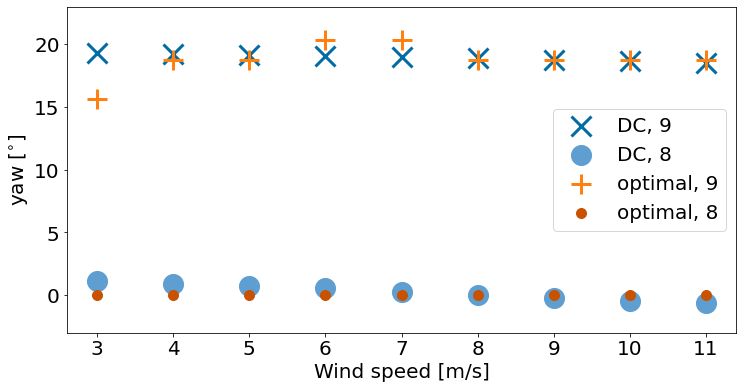

In [18]:
t1_9t_FLORIS = yaws_FLORIS[3][:,7]
t1_8t_FLORIS = yaws_FLORIS[2][:,7]

ws = ws_test
wd = wd_test.repeat(ws.shape[0])
active_turbs = active_turbs_test[3].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t1_9t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_test[2].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t1_8t_DC = scaled_u[:,7,0,0].squeeze().detach().numpy()
    
plt.scatter(ws_test, t1_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_test, t1_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_test, t1_9t_FLORIS, color=colors[1], marker='+', label="optimal, 9")
plt.scatter(ws_test, t1_8t_FLORIS, color=colors[5], marker='.', label="optimal, 8")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.ylim([-3, 23])
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_test, labels=[str(ws) for ws in ws_test.detach().numpy()])
plt.savefig('/Users/jani/Documents/research/windFarmControl/presentations/2023_ACC/figures_larger/yaw_t2.png', 
             bbox_inches='tight')
plt.show()

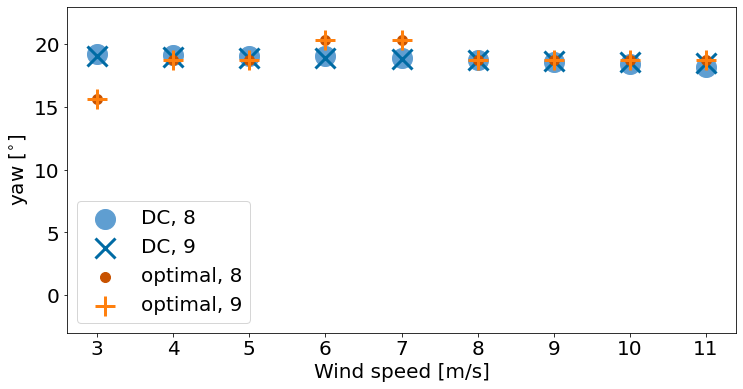

In [19]:
t2_9t_FLORIS = yaws_FLORIS[3][:,4]
t2_8t_FLORIS = yaws_FLORIS[2][:,4]

ws = ws_test
wd = wd_test.repeat(ws.shape[0])
active_turbs = active_turbs_test[3].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t2_9t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()

active_turbs = active_turbs_test[2].repeat(ws.shape[0], 1)
x_coord_rotated, y_coord_rotated, mesh_x_rotated, \
    mesh_y_rotated, mesh_z, inds_sorted = \
    floris_pt.get_turbine_mesh(wd, x_coord, y_coord, z_coord)
_, scaled_u, _ = get_control(model, ws, inds_sorted, ws_min, ws_max, \
    active_turbs=active_turbs)
t2_8t_DC = scaled_u[:,4,0,0].squeeze().detach().numpy()

plt.scatter(ws_test, t2_8t_DC, color=colors[4], marker='o', label="DC, 8")
plt.scatter(ws_test, t2_9t_DC, color=colors[0], marker='x', label="DC, 9")
plt.scatter(ws_test, t2_8t_FLORIS, color=colors[5], marker='.', label="optimal, 8")
plt.scatter(ws_test, t2_9t_FLORIS, color=colors[1], marker='+', label="optimal, 9")
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r'yaw $[^{\circ}]$')
plt.ylim([-3, 23])
plt.legend()
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.xticks(ticks=ws_test, labels=[str(ws) for ws in ws_test.detach().numpy()])
plt.savefig('/Users/jani/Documents/research/windFarmControl/presentations/2023_ACC/figures_larger/yaw_t1.png', 
             bbox_inches='tight')
plt.show()

## Testing numerical results

In [12]:
# estimate runtime FLORIS
runtime_FLORIS = 0.
N_repeat = 0
for i in range(len(runtimes)):
    # 9c(i+2) - {repeats, only 1 turbine active, no turbines active}
    N = 2**(i+2) - N_repeat - (i+2) - 1
    runtime_FLORIS += N*runtimes[i]
    N_repeat += N

runtime_FLORIS, runtime_DC

(769.2039902210236, 83.2388653755188)

In [13]:
# percent error in power from DC vs. FLORIS:
# mean, max (DC better than FLORIS), min (FLORIS better than DC)
err = (np.array(powers_DC) - np.array(powers_FLORIS))/(np.array(powers_FLORIS))*100.
np.round(np.mean(err), 2), np.round(np.max(err), 2), np.round(np.min(err), 2)

(-0.06, 0.13, -0.78)